In [1]:
# !pip3 install langchain-openai

from langchain_openai import ChatOpenAI

llm = ChatOpenAI()

In [2]:
llm.invoke("how can langsmith help with testing?")

AIMessage(content='Langsmith can help with testing in the following ways:\n\n1. Automated testing: Langsmith can be used to write automated test scripts and test cases, making it easier to run tests repeatedly and quickly.\n\n2. Test data generation: Langsmith can be used to generate test data for various scenarios, helping to ensure complete test coverage.\n\n3. Integration testing: Langsmith can be used to test the integration of different components or systems, helping to identify any issues with communication between them.\n\n4. Performance testing: Langsmith can be used to simulate high loads and stress conditions on a system, helping to identify performance bottlenecks and areas for improvement.\n\n5. Regression testing: Langsmith can be used to automate regression tests, ensuring that new changes do not break existing functionality.\n\nOverall, Langsmith can help streamline the testing process, improve test coverage, and identify issues early in the development cycle.', response

In [3]:
from langchain_core.prompts import ChatPromptTemplate
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are world class technical documentation writer."),
    ("user", "{input}")
])

In [4]:
chain = prompt | llm 

In [5]:
chain.invoke({"input": "how can langsmith help with testing?"})

AIMessage(content='Langsmith can help with testing in several ways:\n\n1. Automated testing: Langsmith can generate test cases automatically based on the specifications provided. This can save time and effort in writing test cases manually.\n\n2. Test data generation: Langsmith can create test data for various scenarios, helping to ensure comprehensive test coverage.\n\n3. Test script generation: Langsmith can assist in creating test scripts for automated testing frameworks, making it easier to automate the testing process.\n\n4. Test result analysis: Langsmith can analyze test results and provide insights into areas that need further testing or improvement.\n\n5. Regression testing: Langsmith can help in automating regression testing, ensuring that new changes do not introduce unexpected issues in the software.\n\nOverall, Langsmith can streamline the testing process, improve test coverage, and help in identifying and fixing issues early in the development lifecycle.', response_metada

In [6]:
from langchain_core.output_parsers import StrOutputParser

output_parser = StrOutputParser()

In [9]:
chain.invoke({"input": "how can langsmith help with testing?"})

'Langsmith can assist with testing in a variety of ways by providing language-related tools and functionalities that can improve the efficiency and effectiveness of testing processes. Here are some ways Langsmith can help with testing:\n\n1. Language-specific testing tools: Langsmith can provide tools tailored to specific programming languages or frameworks that allow for more efficient testing of code written in those languages. These tools can help with tasks such as unit testing, integration testing, and performance testing.\n\n2. Syntax and code analysis: Langsmith can help identify syntax errors, coding standards violations, and other issues in code that can impact the quality of testing. By providing code analysis and suggestions for improvement, Langsmith can help developers write cleaner and more reliable code for testing.\n\n3. Automated translation testing: For applications that require support for multiple languages, Langsmith can help automate the testing of translation acc

In [8]:
chain = prompt | llm | output_parser

## RETRIEVAL CHAIN

![notes_images/retrieval_design_for_vector_store.png](notes_images/retrieval_design_for_vector_store.png)

In order to properly answer the original question ("how can langsmith help with testing?"), we need to provide additional context to the LLM. We can do this via retrieval. Retrieval is useful when you have too much data to pass to the LLM directly. You can then use a retriever to fetch only the most relevant pieces and pass those in.

In this process, we will look up relevant documents from a Retriever and then pass them into the prompt. A Retriever can be backed by anything - a SQL table, the internet, etc - but in this instance we will populate a vector store and use that as a retriever. For more information on vectorstores, see this documentation.

First, we need to load the data that we want to index. In order to do this, we will use the WebBaseLoader. This requires installing BeautifulSoup:

Next, we need to index it into a vectorstore. This requires a few components, namely an embedding model and a vectorstore.

For embedding models, we once again provide examples for accessing via API or by running local models.

OpenAI (API)



In [11]:
# !pip3 install beautifulsoup4

from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://docs.smith.langchain.com/user_guide")

docs = loader.load()

In [ ]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()

# Facebook AI Similarity Search (Faiss) : Small Vector Store

Do not use : https://python.langchain.com/docs/integrations/vectorstores/faiss

Use : https://python.langchain.com/docs/integrations/vectorstores/faiss_async

It is a library for efficient similarity search and clustering of dense vectors. It contains algorithms that search in sets of vectors of any size, up to ones that possibly do not fit in RAM. It also contains supporting code for evaluation and parameter tuning.

The inverted file from “Video google: A text retrieval approach to object matching in videos.”, Sivic & Zisserman, ICCV 2003. This is the key to non-exhaustive search in large datasets. Otherwise all searches would need to scan all elements in the index, which is prohibitive even if the operation to apply for each element is fast

The product quantization (PQ) method from “Product quantization for nearest neighbor search”, Jégou & al., PAMI 2011. This can be seen as a lossy compression technique for high-dimensional vectors, that allows relatively accurate reconstructions and distance computations in the compressed domain.

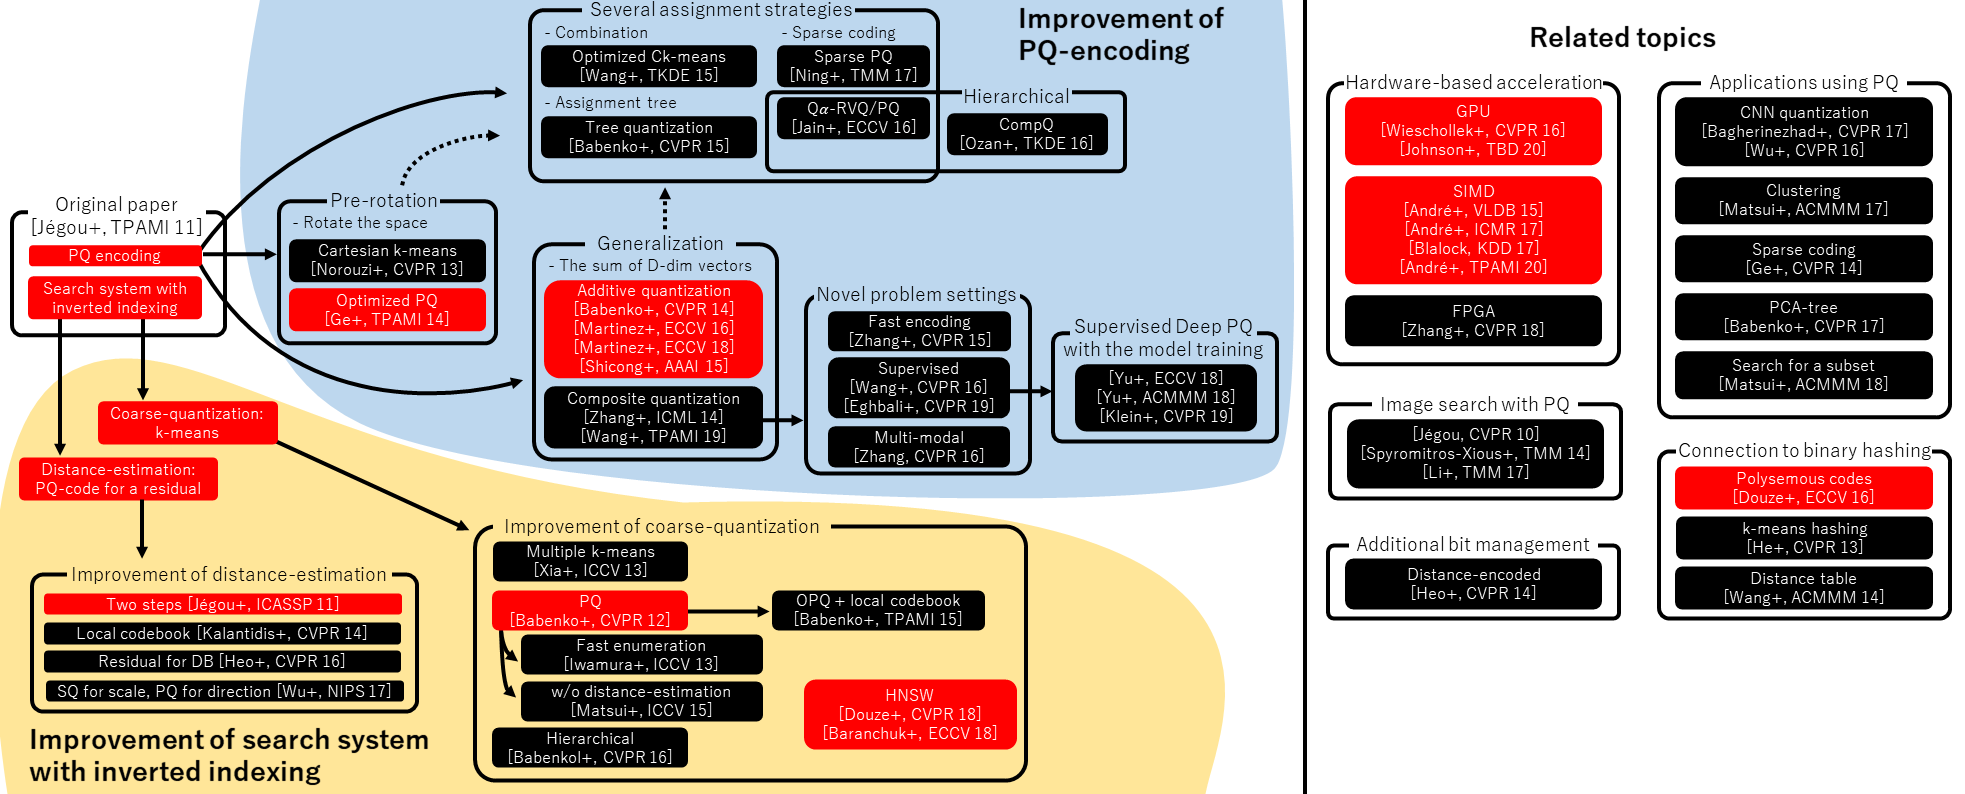

In [16]:
# !pip install faiss-cpu

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()

In [17]:
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter


text_splitter = RecursiveCharacterTextSplitter()
documents = text_splitter.split_documents(docs)
vector = FAISS.from_documents(documents, embeddings)

In [18]:
from langchain.chains.combine_documents import create_stuff_documents_chain

prompt = ChatPromptTemplate.from_template("""Answer the following question based only on the provided context:

<context>
{context}
</context>

Question: {input}""")

document_chain = create_stuff_documents_chain(llm, prompt)

In [19]:
from langchain_core.documents import Document

document_chain.invoke({
    "input": "how can langsmith help with testing?",
    "context": [Document(page_content="langsmith can let you visualize test results")]
})

'Langsmith can help with testing by allowing you to visualize test results.'

In [20]:
from langchain.chains import create_retrieval_chain

retriever = vector.as_retriever()
retrieval_chain = create_retrieval_chain(retriever, document_chain)

In [21]:
response = retrieval_chain.invoke({"input": "how can langsmith help with testing?"})
print(response["answer"])

# LangSmith offers several features that can help with testing:...

LangSmith can help with testing by allowing developers to create datasets, run tests on LLM applications, upload test cases in bulk, create custom evaluations, and compare results for different configurations. It also provides a playground environment for rapid iteration and experimentation, as well as monitoring tools for tracking key metrics and debugging production issues. Additionally, LangSmith supports feedback collection, run annotation, and A/B testing to improve the performance of LLM applications.


Conversation Retrieval Chain

https://python.langchain.com/docs/get_started/quickstart#conversation-retrieval-chain

The chain we've created so far can only answer single questions. One of the main types of LLM applications that people are building are chat bots. So how do we turn this chain into one that can answer follow up questions?

We can still use the create_retrieval_chain function, but we need to change two things:

The retrieval method should now not just work on the most recent input, but rather should take the whole history into account.
The final LLM chain should likewise take the whole history into account

In [22]:
from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import MessagesPlaceholder

# First we need a prompt that we can pass into an LLM to generate this search query

prompt = ChatPromptTemplate.from_messages([
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    ("user", "Given the above conversation, generate a search query to look up in order to get information relevant to the conversation")
])
retriever_chain = create_history_aware_retriever(llm, retriever, prompt)

In [23]:
from langchain_core.messages import HumanMessage, AIMessage

chat_history = [HumanMessage(content="Can LangSmith help test my LLM applications?"), AIMessage(content="Yes!")]
retriever_chain.invoke({
    "chat_history": chat_history,
    "input": "Tell me how"
})

[Document(page_content='Skip to main content🦜️🛠️ LangSmith DocsLangChain Python DocsLangChain JS/TS DocsLangSmith API DocsSearchGo to AppLangSmithUser GuideSetupPricing (Coming Soon)Self-HostingTracingEvaluationMonitoringPrompt HubProxyUser GuideOn this pageLangSmith User GuideLangSmith is a platform for LLM application development, monitoring, and testing. In this guide, we’ll highlight the breadth of workflows LangSmith supports and how they fit into each stage of the application development lifecycle. We hope this will inform users how to best utilize this powerful platform or give them something to consider if they’re just starting their journey.Prototyping\u200bPrototyping LLM applications often involves quick experimentation between prompts, model types, retrieval strategy and other parameters.\nThe ability to rapidly understand how the model is performing — and debug where it is failing — is incredibly important for this phase.Debugging\u200bWhen developing new LLM applications,